Notebook designed to minimize mistie for crossing radar tracks with intersecting interpretations
Following methods of Herkommer and Whitney, 1994

BST 08OCT2020
python3

### psuedocode ###
1. read in dataframe containing radar picks
2. convert points in each track to continuous linestring
3. find all intersection points for all linestrings
4. linearly interpolate between two traces surrounding intersection
5. build statistical dataframe with difference in surface elevation, bed elevation, and ice thickness between tracks at each intersection
6. get actual elevation at tie point as average of two linearly interpolated measurements
7. mistie correction is achieved by a constant shift to each line based on the average mistie for all intersections on that line to the tie point averaged elevation measurement


To solve the inverse problem to determine the bulk shift mistie correction for each track:

data equation:
$d = Gm + e$

where $d$ is the data vector cotaining track misties, $G$ is the design matrix, $m$ is the model vector containing mistie corrections, and $e$ is the error.

Following Herkommmer and Whitney, 1994, $G$ is singular if any of the tracks intersect at least once. However, since $G$ is a square matrix, there will be some solution $m$. Singularity indicates that there are multiple solutions. The psuedo inverse which has the minimum Euclidean norm is selected so that the correction vector $m$ sums to zero.

Thus, we constrain:

 $Hm = 0$

From Menke eq. 3.63:

$
\begin{bmatrix}
\mathbf{G^{T}G}& \mathbf{H^{T}}\\
\mathbf{H} & 0
\end{bmatrix} 
\begin{bmatrix}
\mathbf{m}\\
\mathbf{\lambda}
\end{bmatrix} = 
\begin{bmatrix}
\mathbf{G^{T}d}\\
\mathbf{h}
\end{bmatrix}  
$

where $\mathbf{\lambda}$ is the Lagrange multiplier.

Then, the correction vector estimate, $\mathbf{m^{est}}$ can be found such that:

$\mathbf{m^{est}} = 
\begin{bmatrix}
\mathbf{G^{T}G}& \mathbf{H^{T}}\\
\mathbf{H} & 0
\end{bmatrix}^{\mathbf{T}}
\begin{bmatrix}
\mathbf{G^{T}d}\\
\mathbf{h}
\end{bmatrix} 
$


In [1]:
### impots ###
import sys, os, itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
from datetime import datetime
pd.set_option('display.max_rows', 500)

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]

In [2]:
### function declarations ###
R = 6367000     # earth's radius in meters

def haversinedist_point_array(plon, plat, lonarray, latarray):
    """
    calculate the great circle distance between points on the earth (specified in decimal degrees)
    """
    plon, plat, lonarray, latarray = map(np.radians, [plon, plat, lonarray, latarray])  # map lat, lon to radians

    dlon = lonarray - plon
    dlat = latarray - plat

    a = np.sin(dlat/2.0)**2 + np.cos(plat) * np.cos(latarray) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = R * c
    return m

def track_crossings(lines):
    """ 
    append track names and point to crossings list for each track intersection
    """
    crossings = []
    for line1,line2 in  itertools.combinations(lines, 2):
        if  line1[1].intersects(line2[1]):
            crossing = line1[1].intersection(line2[1])
            if "Point" == crossing.type:
                crossings.append([line1[0],line2[0],crossing])
            elif "MultiPoint" == crossing.type:
                for pt in crossing:
                    crossings.append([line1[0],line2[0],pt])
            elif "MultiLineString" == crossing.type:
                multiLine = [line for line in crossing]
                first_coords = multiLine[0].coords[0]
                last_coords = multiLine[len(multiLine)-1].coords[1]
                crossings.append([line1[0],Point(first_coords[0], first_coords[1])])
                crossings.append([line2[0],Point(last_coords[0], last_coords[1])])
    return crossings

def interp3d(x1, y1, z1, x2, y2, z2 , x, y):
    """
    trilinear interpolation to get z value at point between two 3d points
    """
    if (x1==x2) & (y1==y2):
        z = (z1+z2)/2
    else:
        b1 = np.sqrt((x2 - x1)**2 + (y2 - y1 )**2)  # hypot between given x and y points
        b2 = np.sqrt((x - x1)**2 + (y - y1)**2)     # hypot between first x and y point and point of interest
        z =   z1 + b2*(z2 - z1) / b1                # calculate z value at point of interest

    return z

# get interpolated values at intersection point
def comp_crossings(picks_df, crossings_list, thresh_dist):

    rem_idx = []        # indices of crossings list elements to remove if distance between closes points to  intersection are above threshold
    # initialize arrays to hold interpolated values
    lon_arr = np.array(())
    lat_arr = np.array(())
    track0_arr = np.array(())
    track1_arr = np.array(())
    zsrf0_arr = np.array(())
    zsrf1_arr = np.array(())
    zbed0_arr = np.array(())
    zbed1_arr = np.array(())
    thick0_arr = np.array(())
    thick1_arr = np.array(())

    # loop through crossings
    for _i, crossing in enumerate(crossings_list):
        pt = crossing[2]
        df_sub0 = picks_df[picks_df["track"]==crossing[0]]
        df_sub1 = picks_df[picks_df["track"]==crossing[1]]
        
        # get distance of each point in track to intersection point
        dist0 = haversinedist_point_array(df_sub0["lon"].to_numpy(), df_sub0["lat"].to_numpy(), 
                pt.x, pt.y)
        dist1 = haversinedist_point_array(df_sub1["lon"].to_numpy(), df_sub1["lat"].to_numpy(), 
                pt.x, pt.y)

        # make sure closest point to each intersection is below threshold distance specified
        if dist0.min() < thresh and dist1.min() < thresh_dist:
            # sort distances to get two closest indices
            t0sort = np.argsort(dist0)
            t1sort = np.argsort(dist1)

            # get lon, lat, surface elev, thickness, and bed elev for two closest points to intersection for each track
            x0 = [df_sub0["lon"].iloc[t0sort[0]], df_sub0["lon"].iloc[t0sort[1]]]
            y0 = [df_sub0["lat"].iloc[t0sort[0]], df_sub0["lat"].iloc[t0sort[1]]]
            zsrf0 = [df_sub0["srf_elev"].iloc[t0sort[0]], df_sub0["srf_elev"].iloc[t0sort[1]]]
            zbed0 = [df_sub0["bed_elev"].iloc[t0sort[0]], df_sub0["bed_elev"].iloc[t0sort[1]]]
            thick0 = [df_sub0["srf_bed_thick"].iloc[t0sort[0]], df_sub0["srf_bed_thick"].iloc[t0sort[1]]]

            x1 = [df_sub1["lon"].iloc[t1sort[0]], df_sub1["lon"].iloc[t1sort[1]]]
            y1 = [df_sub1["lat"].iloc[t1sort[0]], df_sub1["lat"].iloc[t1sort[1]]]
            zsrf1 = [df_sub1["srf_elev"].iloc[t1sort[0]], df_sub1["srf_elev"].iloc[t1sort[1]]]
            zbed1 = [df_sub1["bed_elev"].iloc[t1sort[0]], df_sub1["bed_elev"].iloc[t1sort[1]]]
            thick1 = [df_sub1["srf_bed_thick"].iloc[t1sort[0]], df_sub1["srf_bed_thick"].iloc[t1sort[1]]]

            # get linearly interpolated values for each track at intersection point
            zsrf0_cross = interp3d(x0[0],y0[0],zsrf0[0],x0[1],y0[1],zsrf0[1],pt.x,pt.y)
            zbed0_cross = interp3d(x0[0],y0[0],zbed0[0],x0[1],y0[1],zbed0[1],pt.x,pt.y)
            thick0_cross = interp3d(x0[0],y0[0],thick0[0],x0[1],y0[1],thick0[1],pt.x,pt.y)

            zsrf1_cross = interp3d(x1[0],y1[0],zsrf1[0],x1[1],y1[1],zsrf1[1],pt.x,pt.y)
            zbed1_cross = interp3d(x1[0],y1[0],zbed1[0],x1[1],y1[1],zbed1[1],pt.x,pt.y)
            thick1_cross = interp3d(x1[0],y1[0],thick1[0],x1[1],y1[1],thick1[1],pt.x,pt.y)

            # add values to arrays
            lon_arr = np.append(lon_arr, pt.x)
            lat_arr = np.append(lat_arr, pt.y)

            track0_arr = np.append(track0_arr, crossing[0])
            zsrf0_arr = np.append(zsrf0_arr, zsrf0_cross)
            zbed0_arr = np.append(zbed0_arr, zbed0_cross)
            thick0_arr = np.append(thick0_arr, thick0_cross)

            track1_arr = np.append(track1_arr, crossing[1])
            zsrf1_arr = np.append(zsrf1_arr, zsrf1_cross)
            zbed1_arr = np.append(zbed1_arr, zbed1_cross)
            thick1_arr = np.append(thick1_arr, thick1_cross)        

        # if closest point further than threshold, remove crossing
        else:
            rem_idx.append(_i)

    # remove crossings where closes points are above threshold distance
    for idx in sorted(rem_idx, reverse = True):  
        del crossings[idx] 

    # build df
    crossings_df = pd.DataFrame({"lon":lon_arr, "lat":lat_arr,
                                "track0":track0_arr, "zsrf0":zsrf0_arr, "zbed0":zbed0_arr, "thick0":thick0_arr,
                                "track1": track1_arr, "zsrf1":zsrf1_arr, "zbed1":zbed1_arr, "thick1":thick1_arr,
                                "dzsrf":np.abs(zsrf0_arr-zsrf1_arr), "dzbed":np.abs(zbed0_arr-zbed1_arr),
                                "dthick":np.abs(thick0_arr-thick1_arr)})
    return crossings_df


def plot_stats(crossings_df):
    # plot stats
    stats_df = crossings_df[["dzsrf","dzbed","dthick"]]

    fig, axes = plt.subplots(3, 1,sharex=True,figsize=((12,10)))
    for i, (name, col) in enumerate(stats_df.iteritems()):
        ax = axes[i]
        col.hist(ax=ax,bins=25)
        ax.axvline(col.mean(), color='r', linestyle='dashed', linewidth=1,label='mean')
        ax.axvline(col.mean()-col.std(), color='k', linestyle='dashed', linewidth=1,label=r'$1\sigma$')
        ax.axvline(col.mean()+col.std(), color='k', linestyle='dashed', linewidth=1)
        ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
        ax2.set_ylim(0)
        ax.set_xlim([-25, 150])
        print("mean " + name + ": " + str(col.mean()) + " +/- " + str(col.std()))


    axes[0].legend()
    axes[i].set_xlabel("crossover mismatch [m]")
    plt.show()

In [3]:
### params ###
dpath = "G:/OIB/OIB-AK_radar/mala/"
# now let's try with some malaspin data
df = pd.read_csv(dpath + "merged_pick_bst_malaspina_low.csv")
# filter null points
df = df[df.bed_elev.notnull()]
thresh = 50                # distance threshold between crossover points [m]

In [4]:
df.head()

,fid2,fid,track,trace,lon,lat,elev,srf_sample,srf_twtt,srf_elev,srf_amp,bed_sample,bed_twtt,bed_elev,bed_amp,srf_bed_thick
0,2,2,IRARES1B_20160528-224052,1,-140.498526,59.793948,518.566002,217,0.000002,193.853,0.053859,425,0.000004,18.182531,0.026683,175.670469
1,3,3,IRARES1B_20160528-224052,2,-140.498735,59.793983,518.851000,215,0.000002,196.164,0.043868,422,0.000004,21.338099,0.022732,174.825901
2,4,4,IRARES1B_20160528-224052,3,-140.498945,59.794018,519.129999,214,0.000002,198.633,0.037243,421,0.000004,23.807088,0.019011,174.825912
3,5,5,IRARES1B_20160528-224052,4,-140.499154,59.794053,519.399997,213,0.000002,200.635,0.036701,419,0.000004,26.653667,0.016989,173.981333
4,6,6,IRARES1B_20160528-224052,5,-140.499321,59.794080,519.606996,212,0.000002,201.195,0.036678,418,0.000004,27.213676,0.012478,173.981324


In [5]:
# convert points in each track to linestring grouped by track
# zip the coordinates into a point object and convert to a geodataframe
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = GeoDataFrame(df, geometry=geometry)

# aggregate these points with the groupby
gdf2 = gdf.groupby(["track"])["geometry"].apply(lambda x: LineString(x.tolist()))
gdf2 = GeoDataFrame(gdf2, geometry="geometry")

# compile list of lines with linestring
lines = list(gdf2["geometry"])
lines = [tuple((fname, lines[_i])) for _i, fname in enumerate(gdf2.index.values)]

# get all track linestring crossings
crossings = track_crossings(lines)

# each sublist should have: ['track0', 'track1', shapelyPoint]
print(crossings[0])
print(len(crossings))

['IRARES1B_20160528-224052', 'IRARES1B_20160529-001049', <shapely.geometry.point.Point object at 0x000001EEBE1EC4A8>]
1102


In [6]:
# compare radar measurements at each crossing
crossings_df = comp_crossings(df, crossings, thresh)

In [7]:
# output crossover comparison df
crossings_df.to_csv(dpath + "malaspina_low_xover.csv", index=False)

mean dzsrf: 12.58184765045201 +/- 14.910153186562196
mean dzbed: 27.455329482216985 +/- 23.326741585181612
mean dthick: 27.606805552029495 +/- 23.451812257160462


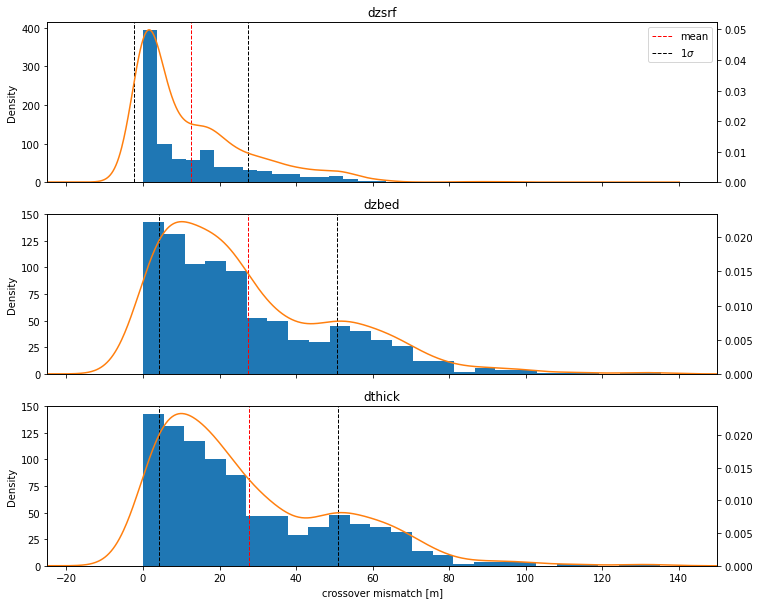

In [8]:
# plot stats
plot_stats(crossings_df)

In [9]:
crossings_df[['dzsrf','dzbed','dthick']].describe()

,dzsrf,dzbed,dthick
count,934.000000,934.000000,934.000000
mean,12.581848,27.455329,27.606806
std,14.910153,23.326742,23.451812
min,0.000000,0.034200,0.000000
25%,0.713336,9.163842,8.856371
50%,6.587102,21.041014,20.269675
75%,19.203434,41.699602,43.628523
max,93.450158,135.444131,135.131131


In [10]:
# filter out two parallel tracks messing with xover stats
t1 = "IRUAFHF1B_20160528-223259"
t2 = "IRARES1B_20160528-224052"

crossings_filt = crossings_df[~((crossings_df.track0==t2) & (crossings_df.track1==t1))]
crossings_filt[['dzsrf','dzbed','dthick']].describe()

,dzsrf,dzbed,dthick
count,733.000000,733.000000,733.000000
mean,15.865198,18.711497,18.868193
std,15.266973,15.165583,15.426706
min,0.002467,0.034200,0.000000
25%,3.145777,7.360665,7.129491
50%,11.918248,16.098199,15.524145
75%,23.897989,25.725156,25.975807
max,93.450158,92.091776,78.783731


mean dzsrf: 15.865197739758969 +/- 15.266972531185923
mean dzbed: 18.711497211900454 +/- 15.165582892938204
mean dthick: 18.86819313340085 +/- 15.42670565273406


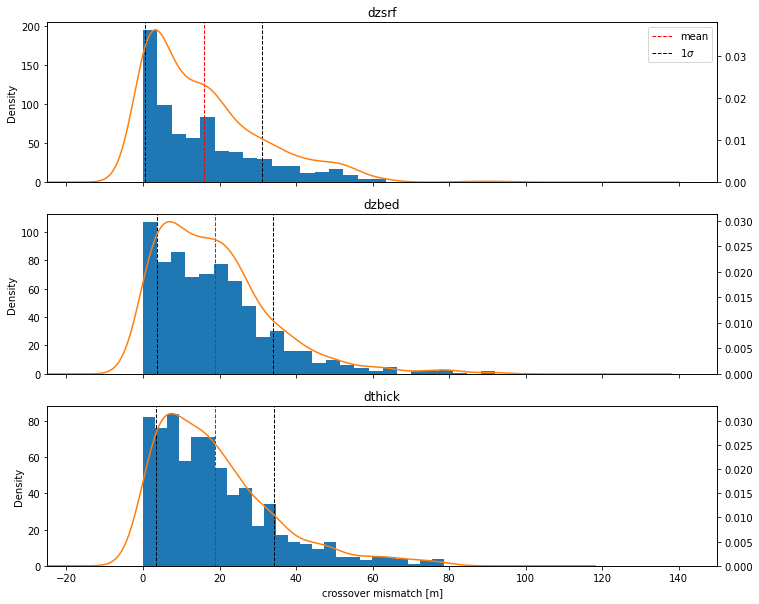

In [11]:
# plot stats
plot_stats(crossings_filt)

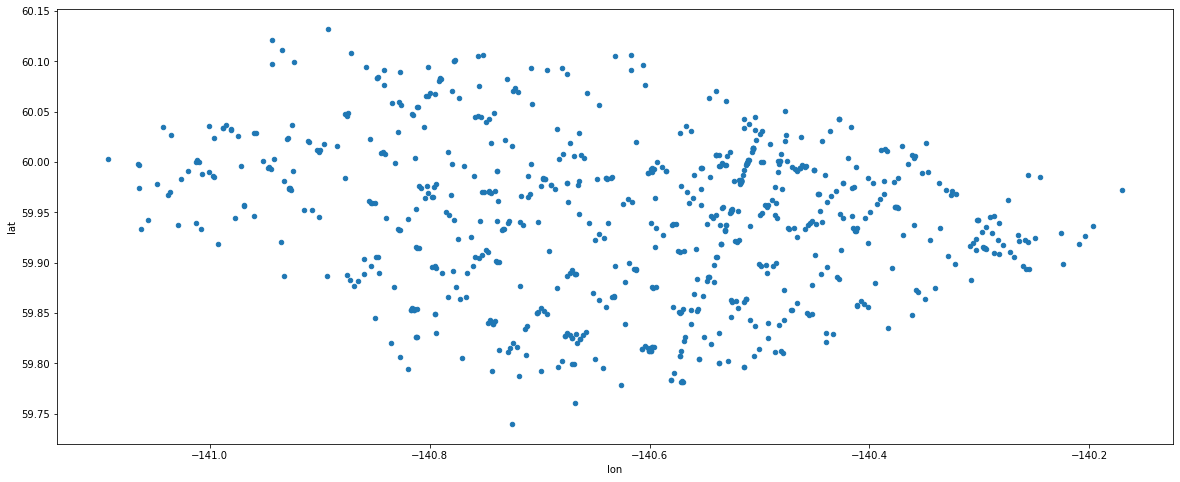

In [12]:
crossings_filt.plot.scatter(x="lon",y="lat")

In [ ]:
# output crossover comparison df
crossings_filt.to_csv(dpath + "malaspina_low_xover.csv", index=False)

In [35]:
# optionally filter crossings only for specific years
crossings_2018a = crossings_df[crossings_df["track0"].str.contains("2018")]
# crossings_2018a = crossings_2018a[~crossings_2018a["track1"].str.contains("2018")]
crossings_2018a = crossings_2018a[crossings_2018a["track1"].str.contains("2019|2020")]


crossings_2018b = crossings_df[crossings_df["track1"].str.contains("2018")]
# crossings_2018b = crossings_2018b[~crossings_2018b["track0"].str.contains("2018")]
crossings_2018b = crossings_2018b[crossings_2018b["track0"].str.contains("2019|2020")]

crossings_2018 = pd.concat([crossings_2018a, crossings_2018b], ignore_index=True)
# tmp = crossings_df[(crossings_df["track0"]=="20180819-215243")|(crossings_df["track1"]=="20180819-215243")]
crossings_2018[['dzsrf','dzbed','dthick']].describe()
# bedoffset = (tmp["zbed0"].values - tmp["zbed1"].values)
# srfoffset = (tmp["zsrf0"].values - tmp["zsrf1"].values)
# print("surface offset: ",srfoffset.mean(), " +/- ", srfoffset.std(), "\nbed offset: ",bedoffset.mean(), " +/- ", srfoffset.std())

,dzsrf,dzbed,dthick
count,66.000000,66.000000,66.000000
mean,6.601697,82.266094,88.526242
std,3.281188,26.173017,26.525972
min,0.264681,15.776973,20.269666
25%,4.407238,69.467243,77.014025
50%,7.123833,82.766846,87.679864
75%,8.891516,96.677437,103.757501
max,14.139718,143.179734,154.069842


In [46]:
crossings_2018

,lon,lat,track0,zsrf0,zbed0,thick0,track1,zsrf1,zbed1,thick1,dzsrf,dzbed,dthick
0,-142.944042,61.502053,IRARES1B_20180520-184949,691.781431,311.725096,380.056340,IRARES1B_20190925-193003,684.948652,370.768778,314.179874,6.832779,59.043682,65.876466
1,-142.933881,61.492454,IRARES1B_20180520-184949,649.010144,383.815259,265.194900,IRARES1B_20190925-193003,639.938433,429.640606,210.297827,9.071711,45.825347,54.897073
2,-142.925584,61.478053,IRARES1B_20180520-184949,571.600306,377.349284,194.251020,IRARES1B_20190925-193003,572.901542,431.858422,141.043120,1.301235,54.509138,53.207900
3,-142.946750,61.503761,IRARES1B_20180520-184949,698.982055,276.697265,422.284800,IRARES1B_20190925-194248,690.255046,365.940325,324.314721,8.727009,89.243060,97.970079
4,-142.930964,61.488799,IRARES1B_20180520-184949,616.234162,376.376405,239.857760,IRARES1B_20190925-194248,611.741471,392.153377,219.588094,4.492691,15.776973,20.269666
5,-142.946410,61.503565,IRARES1B_20180520-184949,697.470610,278.564116,418.906500,IRARES1B_20200521-213751,690.479471,314.408675,376.070796,6.991139,35.844559,42.835704
6,-142.927003,61.481787,IRARES1B_20180520-184949,600.705017,364.225540,236.479480,IRARES1B_20200521-213751,598.159499,397.151935,201.007564,2.545518,32.926394,35.471916
7,-142.926275,61.480220,IRARES1B_20180520-184949,591.838776,373.939819,217.898960,IRARES1B_20200521-213751,590.134711,412.775106,177.359606,1.704064,38.835286,40.539354
8,-142.937352,61.497258,IRARES1B_20180520-184949,669.625755,375.715537,293.910220,IRARES1B_20200521-224153,664.344765,414.352175,249.992589,5.280990,38.636638,43.917631
9,-142.935956,61.495274,IRARES1B_20180520-184949,658.961261,385.320697,273.640560,IRARES1B_20200521-224153,651.437123,415.930528,235.506596,7.524138,30.609830,38.133964


In [44]:
# see if 2018 bed elevation is always lower than crossing tracks from other years
(crossings_2018["zbed0"] < crossings_2018["zbed1"]).all()

True

mean dzsrf: 6.000688397251333 +/- 5.5673643624474485
mean dzbed: 48.180651482208276 +/- 37.7846178461191
mean dthick: 50.16125889324277 +/- 40.4257592547808


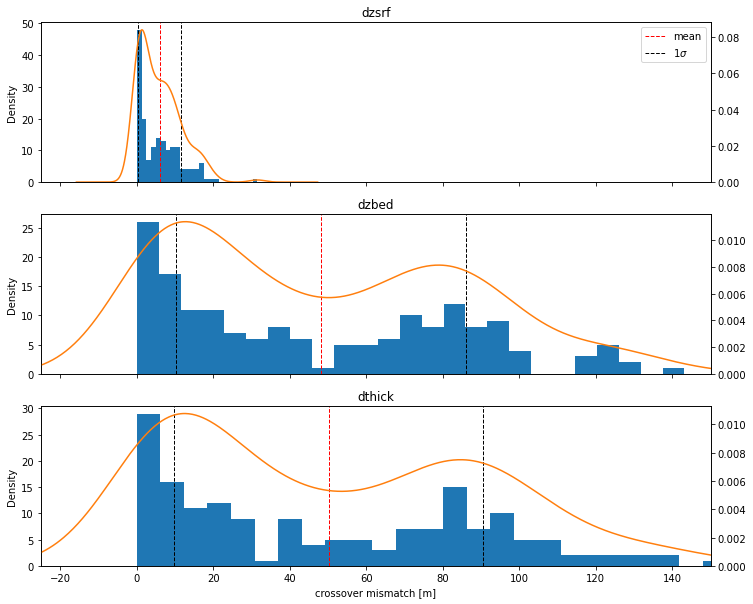

In [47]:
# plot stats
plot_stats(crossings_df)
# we clearly have a bimodal distribution for 2018 offsets, so perhaps not all tracks should have offset correction applied

In [49]:
crossings_2018.sort_values(by=["dzbed"])

,lon,lat,track0,zsrf0,zbed0,thick0,track1,zsrf1,zbed1,thick1,dzsrf,dzbed,dthick
4,-142.930964,61.488799,IRARES1B_20180520-184949,616.234162,376.376405,239.857760,IRARES1B_20190925-194248,611.741471,392.153377,219.588094,4.492691,15.776973,20.269666
9,-142.935956,61.495274,IRARES1B_20180520-184949,658.961261,385.320697,273.640560,IRARES1B_20200521-224153,651.437123,415.930528,235.506596,7.524138,30.609830,38.133964
6,-142.927003,61.481787,IRARES1B_20180520-184949,600.705017,364.225540,236.479480,IRARES1B_20200521-213751,598.159499,397.151935,201.007564,2.545518,32.926394,35.471916
5,-142.946410,61.503565,IRARES1B_20180520-184949,697.470610,278.564116,418.906500,IRARES1B_20200521-213751,690.479471,314.408675,376.070796,6.991139,35.844559,42.835704
8,-142.937352,61.497258,IRARES1B_20180520-184949,669.625755,375.715537,293.910220,IRARES1B_20200521-224153,664.344765,414.352175,249.992589,5.280990,38.636638,43.917631
7,-142.926275,61.480220,IRARES1B_20180520-184949,591.838776,373.939819,217.898960,IRARES1B_20200521-213751,590.134711,412.775106,177.359606,1.704064,38.835286,40.539354
1,-142.933881,61.492454,IRARES1B_20180520-184949,649.010144,383.815259,265.194900,IRARES1B_20190925-193003,639.938433,429.640606,210.297827,9.071711,45.825347,54.897073
2,-142.925584,61.478053,IRARES1B_20180520-184949,571.600306,377.349284,194.251020,IRARES1B_20190925-193003,572.901542,431.858422,141.043120,1.301235,54.509138,53.207900
35,-142.951831,61.492592,IRARES1B_20180529-185120,661.488984,357.345429,304.143552,IRARES1B_20200521-224153,655.817985,414.271084,241.546901,5.670999,56.925655,62.596651
0,-142.944042,61.502053,IRARES1B_20180520-184949,691.781431,311.725096,380.056340,IRARES1B_20190925-193003,684.948652,370.768778,314.179874,6.832779,59.043682,65.876466


In [ ]:
#offsets are mixed between 5/20 & 5/29. does not seem to be a clear pattern so will just apply constant offset correciton

In [36]:
crossings_2018.to_csv(dpath + "kennicott_2018_xover.csv", index=False)

In [21]:
# since we know 20180819-215243 has a time offset and is shifted later in time, let's figure out average mistie for this track and add average back to picks - manual mistie correction
# tmp = crossings_df[(crossings_df["track0"]=="20180819-215243")|(crossings_df["track1"]=="20180819-215243")]
# print(tmp)
# bedoffset = (tmp["zbed0"].values - tmp["zbed1"].values)
# srfoffset = (tmp["zsrf0"].values - tmp["zsrf1"].values)
# print("surface offset: ",srfoffset.mean(), " +/- ", srfoffset.std(), "\nbed offset: ",bedoffset.mean(), " +/- ", srfoffset.std())

# # shift 2018 high pass track
# df_cp = df.copy()
# df_cp.loc[df_cp["track"] == "20180819-215243","subsrfElev"] += bedoffset.mean()
# df_cp.loc[df_cp["track"] == "20180819-215243","gndElev"] += srfoffset.mean()


In [11]:
# # compare radar measurements at each crossing
# crossings_df_shift = comp_crossings(df_cp, crossings, thresh)

mean dzsrf: 9.69491575692261 +/- 11.446307898714055
mean dzbed: 17.490993630007605 +/- 13.640364740627183
mean dthick: 14.104969345408463 +/- 10.390508686524942


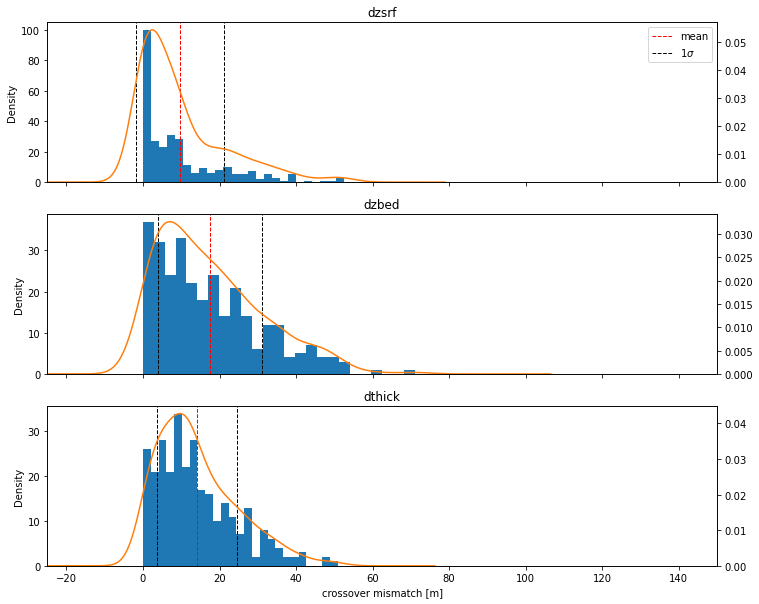

In [12]:
# plot stats
# plot_stats(crossings_df_shift)

In [24]:
# crossings_df_shift[['dzsrf','dzbed','dthick']].describe()

In [14]:
# determine how many times any two tracks intersect to find average mistie
# avmistie = crossings_df_shift.groupby(['track0','track1']).size().reset_index()
# avmistie.rename(columns={0: "count"},inplace=True)
avmistie = []

groups = crossings_df_shift.groupby(['track0','track1'])

for key, value in groups.groups.items():
    # sort tracks by datetime stamp
    tracks = (sorted(key, key=lambda x: datetime.strptime(x, "%Y%m%d-%H%M%S")))
    # create subdataframe with all intersections between the two tracks
    df_sub = crossings_df_shift[((crossings_df_shift["track0"]==tracks[0])
                                &(crossings_df_shift["track1"]==tracks[1]))
                                |((crossings_df_shift["track0"]==tracks[1])
                                &(crossings_df_shift["track1"]==tracks[0]))]

    # add up bed elevation differences, subtracting old from new
    mistie = 0
    for _i in range(len(df_sub)):
        # verify crossing order and add up misties to get avmistie for every pair of tracks that intersect
        if df_sub["track0"].iloc[_i] == tracks[0]:
            mistie += (df_sub["zbed1"].iloc[_i] - df_sub["zbed0"].iloc[_i])
        else:          
            mistie += (df_sub["zbed0"].iloc[_i] - df_sub["zbed1"].iloc[_i])

    avmistie.append([tracks[0], tracks[1], mistie/(_i + 1)])

In [15]:
# investigate avmistie list - each element should be a sublist containing ['track0', 'track1', avg. mistie]
print(avmistie[0])

['20150514-213156', '20150515-011547', -1.7653649206683824]


In [16]:
# determine number of unique tracks in list
crossingtracks = list(set(x for l in avmistie for x in l[0:2]))
# sort by datetime
crossingtracks = (sorted(crossingtracks, key=lambda x: datetime.strptime(x, "%Y%m%d-%H%M%S")))

# create avmistie matrix which contains indices of track ids with data value
avmistie_arr = np.zeros((len(avmistie),3))
for _i, row in enumerate(avmistie):
    avmistie_arr[_i,0] = crossingtracks.index(row[0])
    avmistie_arr[_i,1] = crossingtracks.index(row[1])
    avmistie_arr[_i,2] = row[2]

In [17]:
# see what avmistie_arr looks like
print(avmistie_arr[0,:])

[ 0.         19.         -1.76536492]


In [18]:
# construct deviation vector, b per H&K eq. 3
N = len(crossingtracks)
b = np.zeros(N)

for k in range(N):
    # reset b_k value
    value = 0
    for i in range(N):
        # get index in avmitie_arr where i&k are a set - may be cleaner way to do this
        idx = np.where(((avmistie_arr[:,0]==k) & (avmistie_arr[:,1]==i)) | ((avmistie_arr[:,0]==i) & (avmistie_arr[:,1]==k)))

        if  i < k:
            # add values
            value += avmistie_arr[idx[0],2].sum()
            
        if i > k:
            # subtract
            value -= avmistie_arr[idx[0],2].sum()
    b[k] = value

In [30]:
# see what b looks like
print("b:\n",b)

b:
 [ 4.74478177e+01 -9.64654372e+00  4.29786769e+01  3.53027198e+01
  4.32000045e+01 -3.92102007e+01 -1.76729901e+00  2.24601523e+01
 -1.94679982e+01  6.71231899e+01  5.83025762e+01  1.57164546e+02
  1.22873251e+02  9.40272636e+00  3.94790335e+01 -6.39753126e+00
  1.29724904e+02 -1.86729240e+00  1.92635124e+01  4.23429573e+01
  1.14113489e+01  2.77520583e+02  2.51589417e+01  8.65137868e+00
  4.66973875e+01 -2.48807993e+01  1.08836971e+02  1.20280708e+01
 -4.26840509e+01  4.52043477e+01  1.23442343e+02  8.74625919e+01
  1.09085930e+02 -5.27855982e+00  4.18173194e+01  4.62324154e+01
  1.70784548e+02  8.11544032e+01  2.67033189e+02  2.98253056e+01
  8.53422696e+01  4.21166811e+01  1.60611996e+02  1.17004828e+02
  1.07278158e+02 -8.65137868e+00  8.30779069e+01  9.40251743e+01
  2.90849855e+01  2.14864225e+01 -1.76297673e+01 -3.27501471e+01
 -4.78356725e+01  1.85794961e+01 -2.94827034e+01  1.81962994e+01
 -4.90846791e+01 -5.91604706e+01  5.80080913e+01 -4.78732189e+01
 -5.28633074e+01 -6.5

In [20]:
# construct adjacency matrix, A
A = np.zeros((N, N), dtype=int)
for k in range(avmistie_arr.shape[0]):
    i, j = avmistie_arr[k,:2]
    A[int(i),int(j)] = -1
    A[int(j),int(i)] = -1
    A[int(i),int(i)] += 1
    A[int(j),int(j)] += 1

At = np.transpose(A)
AtA = np.matmul(At, A)
C = np.linalg.pinv(AtA)
Adag = np.matmul(C, At)

m = np.matmul(Adag, b)
c = np.matmul(A, m)

In [29]:
print("A:\n",A)
print()
print("c:\n",c)
print("c-min: ",c.min(),"\nc-max: ", c.max(),"\nc-sum: ", c.sum(),"\nc-mean: ",c.mean(),"\nc-median: ",np.median(c),"\nc-std: ",c.std())

A:
 [[ 2  0  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ... 19 -1 -1]
 [ 0  0  0 ... -1 16  0]
 [ 0  0  0 ... -1  0 22]]

c:
 [ 4.74478177e+01 -9.64654372e+00  4.29786769e+01  3.53027198e+01
  4.32000045e+01 -3.92102007e+01 -1.76729901e+00  2.24601523e+01
 -1.94679982e+01  6.71231899e+01  5.83025762e+01  1.57164546e+02
  1.22873251e+02  9.40272636e+00  3.94790335e+01 -6.39753126e+00
  1.29724904e+02 -1.86729240e+00  1.92635124e+01  4.23429573e+01
  1.14113489e+01  2.77520583e+02  2.51589417e+01  8.65137868e+00
  4.66973875e+01 -2.48807993e+01  1.08836971e+02  1.20280708e+01
 -4.26840509e+01  4.52043477e+01  1.23442343e+02  8.74625919e+01
  1.09085930e+02 -5.27855982e+00  4.18173194e+01  4.62324154e+01
  1.70784548e+02  8.11544032e+01  2.67033189e+02  2.98253056e+01
  8.53422696e+01  4.21166811e+01  1.60611996e+02  1.17004828e+02
  1.07278158e+02 -8.65137868e+00  8.30779069e+01  9.40251743e+01
  2.90849855e+01  2.14864225e+01 -1.76297673e+01 -3.275

In [22]:
print(crossingtracks[np.argmin(c)])

20180818-000438


Text(0, 0.5, 'bed elevation mistie correction')

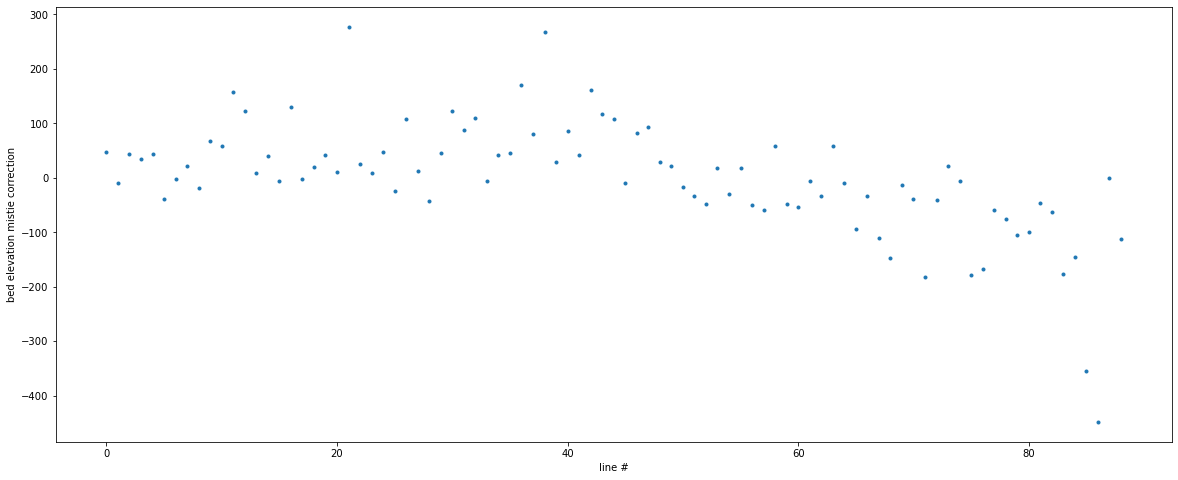

In [31]:
plt.plot(c,'.')
plt.xlabel("line #")
plt.ylabel("bed elevation mistie correction")

In [24]:
# print(mistie_df.sort_values("avgmistie", ascending=False))

In [25]:
# now add the mistie corrections back in
for i, track in enumerate(crossingtracks):
    df_mistie_min = df_cp.copy()
    df_mistie_min.loc[df_mistie_min["track"] == track,"subsrfElev"] += c[i]

In [26]:
# compare radar measurements at each crossing
crossings_df_mistie_min = comp_crossings(df_mistie_min, crossings, thresh)

mean dzsrf: 9.69491575692261 +/- 11.446307898714055
mean dzbed: 34.04272508180811 +/- 37.85596229683491
mean dthick: 14.104969345408463 +/- 10.390508686524942


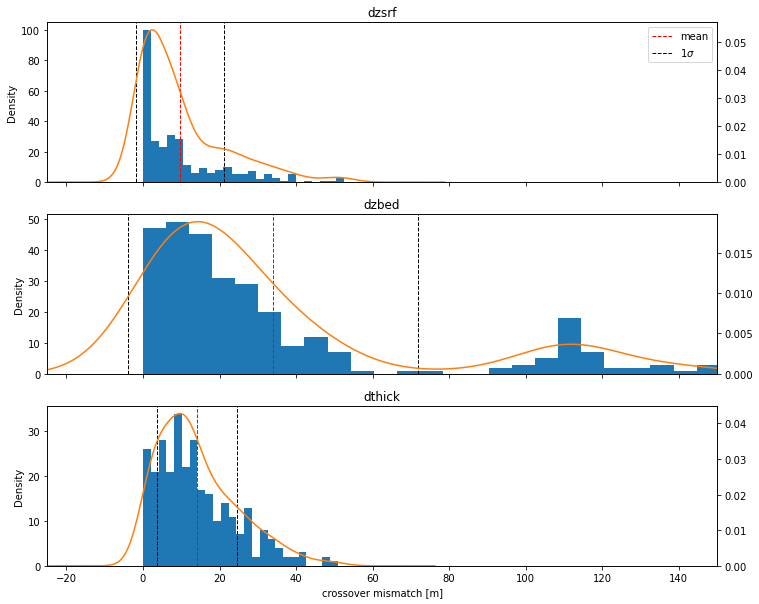

In [27]:
# plot stats
plot_stats(crossings_df_mistie_min)